In [7]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
from hampel import hampel
import seaborn
import matplotlib.pyplot as plt
from tueplots import axes, bundles

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w"})
bundles.beamer_moml()

from utilities.utl import find_lsl_stream, find_nearest, fill_nan, get_channel_labels_ppl_xdf
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData, Epochs



In [8]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [9]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


Max force is 4883 something for c300
Max force is 5894 something for c301
Stream pupil_capture not found
Max force is 6856 something for c302
No pupil data found for c302
Max force is 8514 something for c303
Max force is 5598 something for c304
Max force is 8067 something for c305
Max force is 7033 something for c306
Max force is 9657 something for c307
Max force is 12737 something for c308
Max force is 12044 something for c309
Max force is 9064 something for c310
Max force is 15983 something for p200
Max force is 9105 something for p201
Max force is 4625 something for p202
Max force is 7724 something for p203
Max force is 4975 something for p204
Max force is 6563 something for p205
Max force is 7232 something for p206
Max force is 11349 something for p207
Max force is 9584 something for p208
Max force is 6277 something for p209
Max force is 12857 something for p210
Max force is 6498 something for p211
Max force is 9859 something for p212
Max force is 10403 something for p213
Max force

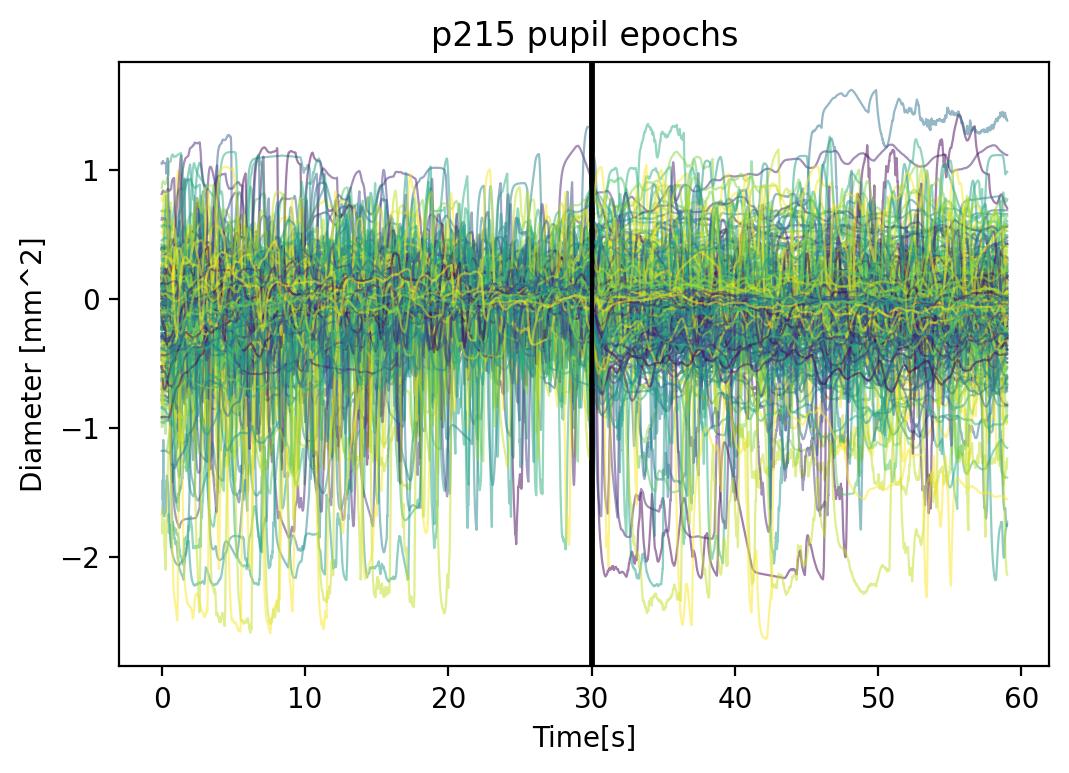

In [10]:
# set params for epoch processing and plotting
cfg_pupil_plot_colors = plt.cm.viridis(np.linspace(0,1,12))
cfg_bl_times = [20,28]
cfg_bl_times.sort()
cfg_trial_times = [35,50]
cfg_trial_times.sort()
cfg_epoch_times =  [-60,0]
cfg_epoch_times.sort()

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms
id = []
n_trial = []
con_view_ang = []
con_feedback = []
per_bad_samples = []
ppl_size = []



for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.eye:
        print(f'No pupil data found for {sub.id}')
        continue

    # extract ppl chn names
    ch_info = sub.eye["info"]["desc"][0]["channels"][0]
    nms_ppl = []
    for i,ch in enumerate(ch_info["channel"]):
        nms_ppl.append(ch_info["channel"][i].get('label')[0])
        

    # epoch data
    eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('end_trial', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1])
    eps.data[eps.data == 0] = np.nan

    # prep pupil data
    ch_oi = ['confidence', 'diameter1_3d']
    idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]   

    # prep single trial pupil data
    for i in range(eps.data.shape[2]):

        id.append(sub.id)
        n_trial.append(i)
        ep = eps.data[idx_ch_oi,:,i]
        ep = pd.DataFrame(ep.T)
        ep.columns = [ch_oi]
        ep = ep.interpolate(method='linear',axis='rows')

        lower_thresh = ep["diameter1_3d"].median(axis=0)-ep["diameter1_3d"].std(axis=0)*1.5
        upper_thresh = ep["diameter1_3d"].median(axis=0)+ep["diameter1_3d"].std(axis=0)*1.5

        idx_bad_samples = np.logical_or(ep.diameter1_3d < lower_thresh,ep.diameter1_3d > upper_thresh)
        per_bad_samples.append(idx_bad_samples.sum() / len(idx_bad_samples))
        ep["diameter1_3d"] = np.where(idx_bad_samples,np.nan,ep.diameter1_3d)
        
        ep = ep.interpolate(method='linear',axis='rows')
        ep["diameter1_3d"] = hampel(ep["diameter1_3d"].squeeze(), window_size=60, n=1, imputation=True).ewm(span = 60).mean()
        ep["diameter1_3d"].ewm(span = 60).mean()

        # do baseline correction
        bl_diam = ep["diameter1_3d"][np.logical_and(eps.times > cfg_bl_times[0],eps.times < cfg_bl_times[1])].mean()
        ep["diameter1_3d"] = ep["diameter1_3d"] - bl_diam
        tmp_pupil_size = ep["diameter1_3d"][np.logical_and(eps.times > cfg_trial_times[0],eps.times < cfg_trial_times[1])].mean()[0]
        ppl_size.append(tmp_pupil_size)

        plt.plot(eps.times,ep["diameter1_3d"].to_numpy(),color=cfg_pupil_plot_colors[i],linewidth=.8, alpha=.5)

    plt.axvline(30,c='k')
    plt.xlabel('Time[s]')
    plt.ylabel('Diameter [mm^2]')
    plt.title(f"{sub.id} pupil epochs")
    plt.savefig(Path.joinpath(dir_plots,f"{sub.id}_pupil_epochs.png"))

    # info per epoch
    con_view_ang.extend(eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2))
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])




In [11]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Pupil size": ppl_size, "Percentage bad pupil samples": per_bad_samples}
all_trials = pd.DataFrame(all_trials)

fname = "all_trials_pupil.csv"

all_trials.to_csv(Path.joinpath(dir_prep,fname))


In [44]:
from scipy.stats import ttest_ind
from scipy import stats
df = all_trials
ppl_z = np.abs(stats.zscore(df['Pupil size']))
df = df[ppl_z <  3]
df_ = df


#define samples
low = df_[df_["Feedback angle"]==0.02]
high = df_[df_["Feedback angle"]==0.44]

#perform independent two sample t-test
t_, p_ = ttest_ind(low['Pupil size'],high['Pupil size'])



Text(0.5, 1.0, 'p:0.002 easy vs. hard')

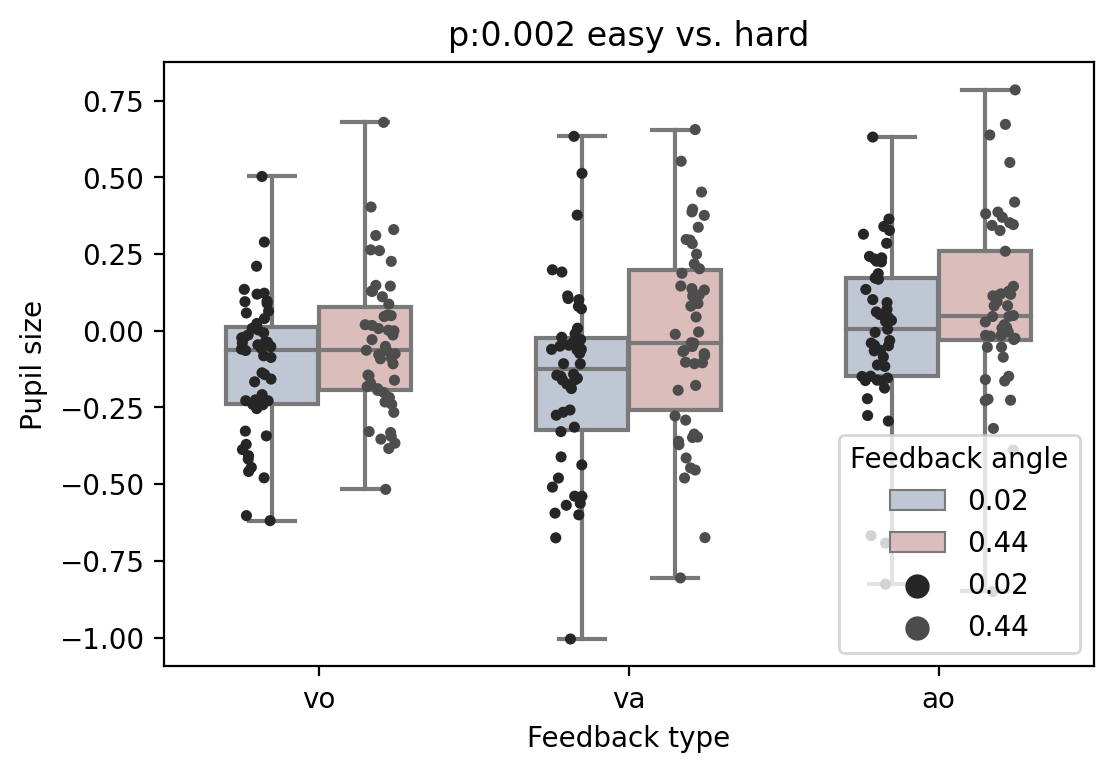

In [45]:
import seaborn as sns

sns.boxplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)

plt.title(f"p:{round(p_,3)} easy vs. hard")